In [429]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

def parse_array_list_str(s):
    try:
        return eval(s, {"array": np.array, "np": np})
    except Exception as e:
        print(f"Parse error: {e}")
        return s

df = pd.read_csv("muller_brown_sweep.csv")
df.sort_values("run_id", inplace=True)

columns_to_parse = ['found_minima', 'found_saddles']

for col in columns_to_parse:
    if col in df.columns:
        df[col] = df[col].apply(parse_array_list_str)

df['found_minima'][0]

og_df = df

In [401]:
from potentials import StandardMullerBrown2D
potential = StandardMullerBrown2D()

known_minima = potential.known_minima()
known_saddles = potential.known_saddles()

def l2_error_to_nearest(point, reference_list):
    return min(np.linalg.norm(np.array(point) - np.array(ref)) for ref in reference_list)

In [402]:
import numpy as np
import pandas as pd

# --- Config ---
N_SEEDS = 3  # adjust as needed

rows = []

def standard_error(arr):
    arr = np.asarray(arr)
    return np.std(arr, ddof=1) / np.sqrt(len(arr)) if len(arr) > 1 else np.nan

def parse_list(val):
    return eval(val) if isinstance(val, str) else val

def pad_and_stack_lists(list_of_lists):
    max_len = max(len(lst) for lst in list_of_lists)
    return np.array([list(lst) + [np.nan] * (max_len - len(lst)) for lst in list_of_lists])

def cumulative_to_diffs(lst):
    """Given cumulative list [x, x+y, x+y+z], return increments [x, y, z]."""
    arr = np.array(lst)
    diffs = np.diff(np.insert(arr, 0, 0))
    return diffs

for i in range(0, len(df), N_SEEDS):
    block = df.iloc[i:i+N_SEEDS]
    if len(block) < N_SEEDS:
        continue  # skip incomplete block

    all_saddles = []
    all_minima = []
    num_saddles_per_seed = []
    num_minima_per_seed = []

    # For each seed, parse and remove duplicates in saddles and minima
    for j in range(N_SEEDS):
        seed_saddles = block.iloc[j]['found_saddles']
        seed_minima = block.iloc[j]['found_minima']

        # Deduplicate saddles and minima using tuple for hashability
        unique_saddles = list({tuple(s) for s in seed_saddles})
        unique_minima = list({tuple(m) for m in seed_minima})

        num_saddles_per_seed.append(len(unique_saddles))
        num_minima_per_seed.append(len(unique_minima))

        all_saddles.extend(unique_saddles)
        all_minima.extend(unique_minima)

    # Now find unique saddles/minima across the entire block to avoid double counting
    all_saddles = list({tuple(s) for s in all_saddles})
    all_minima = list({tuple(m) for m in all_minima})

    saddle_errors = [l2_error_to_nearest(sad, known_saddles) for sad in all_saddles]
    minima_errors = [l2_error_to_nearest(min_, known_minima) for min_ in all_minima]

    bias_counts = block['bias_count'].values

    summary = {
        'run_id': block['run_id'].min(),  # lowest run_id in this block
        'saddle_error_mean': np.mean(saddle_errors),
        'saddle_error_stderr': standard_error(saddle_errors),
        'minima_error_mean': np.mean(minima_errors),
        'minima_error_stderr': standard_error(minima_errors),
        'bias_count_mean': np.mean(bias_counts),
        'bias_count_stderr': standard_error(bias_counts),
        'num_minima_mean': np.mean(num_minima_per_seed),
        'num_minima_stderr': standard_error(num_minima_per_seed),
        'num_saddles_mean': np.mean(num_saddles_per_seed),
        'num_saddles_stderr': standard_error(num_saddles_per_seed),
    }

    energy_lists = [parse_list(val) for val in block['energy_calls_at_each_min']]
    force_lists = [parse_list(val) for val in block['force_calls_at_each_min']]

    # Convert cumulative calls to increments
    energy_increments = [cumulative_to_diffs(lst) for lst in energy_lists]
    force_increments = [cumulative_to_diffs(lst) for lst in force_lists]

    energy_array = pad_and_stack_lists(energy_increments)
    force_array = pad_and_stack_lists(force_increments)

    summary.update({
        'energy_calls_mean': np.nanmean(energy_array, axis=0).tolist(),
        'energy_calls_stderr': (np.nanstd(energy_array, axis=0, ddof=1) / np.sqrt(N_SEEDS)).tolist(),
        'force_calls_mean': np.nanmean(force_array, axis=0).tolist(),
        'force_calls_stderr': (np.nanstd(force_array, axis=0, ddof=1) / np.sqrt(N_SEEDS)).tolist(),

        'mean_force_calls_per_min': np.nanmean(force_array).item(),
        'stdv_force_calls_per_min': np.nanstd(force_array, ddof=1).item(),
        'mean_energy_calls_per_min': np.nanmean(energy_array).item(),
        'stdv_energy_calls_per_min': np.nanstd(energy_array, ddof=1).item(),
    })

    # Copy config values (assuming identical across seeds)
    config_keys = [
        'bias_std_dev_scale', 'bias_covariance', 'bias_height_fraction',
        'bias_height', 'perturbation_size', 'optimizer'
    ]
    for key in config_keys:
        summary[key] = block.iloc[0][key]

    rows.append(summary)

agg_df = pd.DataFrame(rows)


/home/simonnir/venvs/abc_venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [403]:
agg_df = agg_df[
    (agg_df['num_minima_mean'] == 3) &
    (agg_df['num_saddles_mean'] == 2)
].copy()


In [404]:
agg_df

,run_id,saddle_error_mean,saddle_error_stderr,minima_error_mean,minima_error_stderr,bias_count_mean,bias_count_stderr,num_minima_mean,num_minima_stderr,num_saddles_mean,...,mean_force_calls_per_min,stdv_force_calls_per_min,mean_energy_calls_per_min,stdv_energy_calls_per_min,bias_std_dev_scale,bias_covariance,bias_height_fraction,bias_height,perturbation_size,optimizer
40,120,0.375587,0.149124,1.672933e-05,1.179832e-05,69.666667,1.201850,3.0,0.0,2.0,...,3114.222222,3489.420395,3114.222222,3489.420395,0.200000,0.012100,0.200000,7.600000,0.1000,FIRE
41,123,0.366323,0.063022,7.141713e-05,4.292503e-05,41.666667,11.170397,3.0,0.0,2.0,...,354.111111,411.052139,354.111111,411.052139,0.200000,0.012100,0.200000,7.600000,0.1000,Scipy
42,126,0.051051,0.020125,1.672545e-05,1.179882e-05,61.000000,11.239810,3.0,0.0,2.0,...,2726.222222,3246.790445,2726.222222,3246.790445,0.200000,0.012100,0.200000,7.600000,0.0100,FIRE
43,129,0.210641,0.056160,1.540466e-05,1.236877e-05,30.000000,11.135529,3.0,0.0,2.0,...,422.666667,453.939148,422.666667,453.939148,0.200000,0.012100,0.200000,7.600000,0.0100,Scipy
44,132,0.127614,0.072425,1.954561e-05,1.175912e-05,55.333333,13.568755,3.0,0.0,2.0,...,2568.444444,2975.080592,2568.444444,2975.080592,0.200000,0.012100,0.200000,7.600000,0.0010,FIRE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,543,0.313591,0.029429,5.496490e-09,2.052037e-10,1340.333333,99.153641,3.0,0.0,2.0,...,20579.888889,28649.386278,20579.888889,28649.386278,0.071429,0.001543,0.033333,1.266667,0.0010,Scipy
183,549,0.270906,0.021116,5.548886e-09,1.673634e-10,1376.333333,174.938402,3.0,0.0,2.0,...,23383.555556,31040.914758,23383.555556,31040.914758,0.071429,0.001543,0.033333,1.266667,0.0001,Scipy
185,555,0.680642,0.112429,5.356345e-09,2.119807e-10,907.000000,536.646066,3.0,0.0,2.0,...,11583.777778,19961.844822,11583.777778,19961.844822,0.071429,0.001543,0.020000,0.760000,0.1000,Scipy
187,561,0.244405,0.042491,5.356345e-09,2.119807e-10,424.666667,15.059143,3.0,0.0,2.0,...,6879.444444,9117.942697,6879.444444,9117.942697,0.071429,0.001543,0.020000,0.760000,0.0100,Scipy


<ErrorbarContainer object of 3 artists>

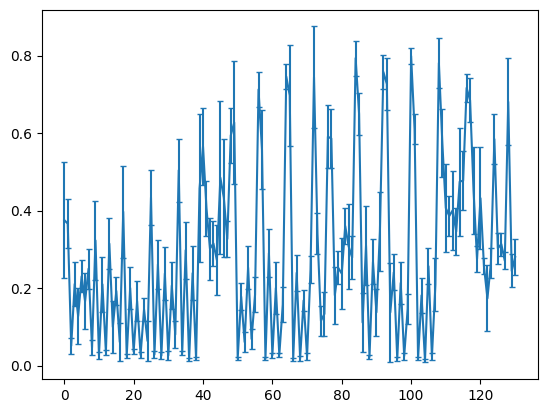

In [405]:
plt.errorbar(range(131), agg_df['saddle_error_mean'], agg_df['saddle_error_stderr'], capsize=2)

In [406]:
contender_params = agg_df[agg_df['num_minima_mean']==3][agg_df['num_saddles_mean']==2]

In [407]:
contender_params.columns

Index(['run_id', 'saddle_error_mean', 'saddle_error_stderr',
       'minima_error_mean', 'minima_error_stderr', 'bias_count_mean',
       'bias_count_stderr', 'num_minima_mean', 'num_minima_stderr',
       'num_saddles_mean', 'num_saddles_stderr', 'energy_calls_mean',
       'energy_calls_stderr', 'force_calls_mean', 'force_calls_stderr',
       'mean_force_calls_per_min', 'stdv_force_calls_per_min',
       'mean_energy_calls_per_min', 'stdv_energy_calls_per_min',
       'bias_std_dev_scale', 'bias_covariance', 'bias_height_fraction',
       'bias_height', 'perturbation_size', 'optimizer'],
      dtype='object')

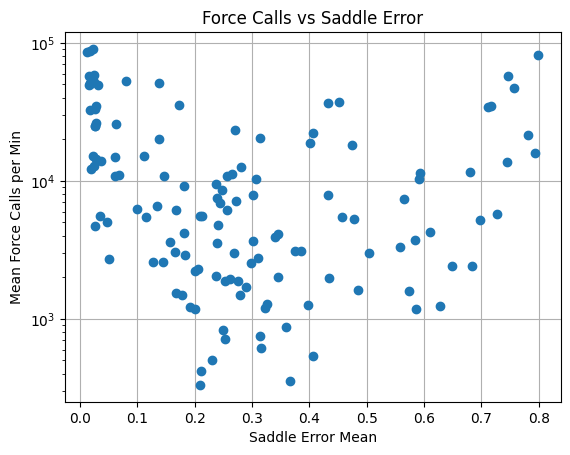

In [408]:
import matplotlib.pyplot as plt

# Filter using a single boolean mask with &
contender_params = agg_df[
    (agg_df['num_minima_mean'] == 3) & 
    (agg_df['num_saddles_mean'] == 2)
]

x = contender_params['saddle_error_mean']
y = contender_params['mean_force_calls_per_min']
yerr = contender_params['stdv_force_calls_per_min']

plt.errorbar(x, y, fmt='o', yerr=0)# yerr=yerr, capsize=3, linewidth=1)
plt.xlabel('Saddle Error Mean')
plt.ylabel('Mean Force Calls per Min')
plt.title('Force Calls vs Saddle Error')
plt.grid(True)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()


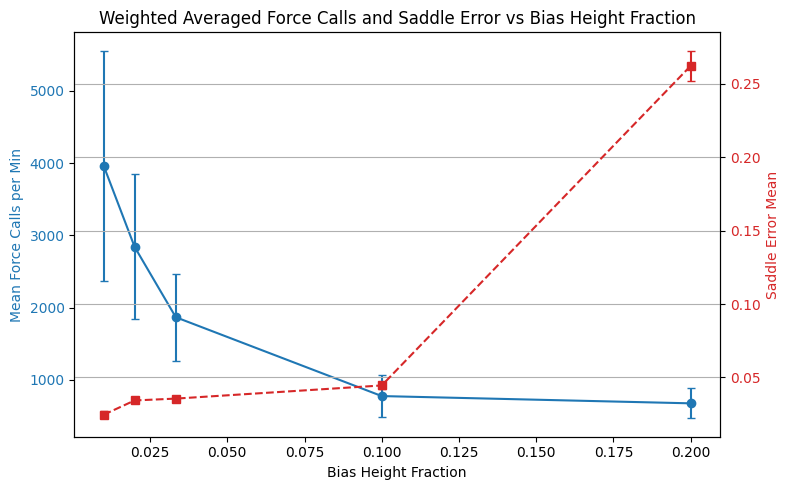

In [409]:
import numpy as np
import matplotlib.pyplot as plt

contender_params = agg_df[
    (agg_df['num_minima_mean'] == 3) & 
    (agg_df['num_saddles_mean'] == 2)
]

def weighted_avg_and_sem(values, sems):
    """
    Compute weighted average and combined SEM given values and their SEMs.
    weights = 1 / variance = 1 / (sem^2)
    """
    values = np.array(values)
    sems = np.array(sems)
    variances = sems ** 2

    # Avoid divide-by-zero by setting zero SEMs to a tiny positive number
    variances[variances == 0] = 1e-12

    weights = 1 / variances
    weighted_avg = np.sum(weights * values) / np.sum(weights)
    combined_variance = 1 / np.sum(weights)
    combined_sem = np.sqrt(combined_variance)
    return weighted_avg, combined_sem

# Group by bias_height_fraction
grouped = []

for bh_frac, group in contender_params.groupby('bias_height_fraction'):
    f_vals = group['mean_force_calls_per_min']
    f_sems = group['stdv_force_calls_per_min']
    s_vals = group['saddle_error_mean']
    s_sems = group['saddle_error_stderr']

    f_avg, f_sem = weighted_avg_and_sem(f_vals, f_sems)
    s_avg, s_sem = weighted_avg_and_sem(s_vals, s_sems)

    grouped.append({
        'bias_height_fraction': bh_frac,
        'mean_force_calls_per_min': f_avg,
        'std_force_calls_per_min': f_sem,
        'mean_saddle_error': s_avg,
        'std_saddle_error': s_sem
    })

grouped_df = pd.DataFrame(grouped).sort_values('bias_height_fraction')

x = grouped_df['bias_height_fraction']
y1 = grouped_df['mean_force_calls_per_min']
y1_err = grouped_df['std_force_calls_per_min']

y2 = grouped_df['mean_saddle_error']
y2_err = grouped_df['std_saddle_error']

fig, ax1 = plt.subplots(figsize=(8,5))

color1 = 'tab:blue'
ax1.set_xlabel('Bias Height Fraction')
ax1.set_ylabel('Mean Force Calls per Min', color=color1)
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', color=color1, capsize=3)
ax1.tick_params(axis='y', labelcolor=color1)
# ax1.set_yscale('log')  # optional

ax2 = ax1.twinx()

color2 = 'tab:red'
ax2.set_ylabel('Saddle Error Mean', color=color2)
ax2.errorbar(x, y2, yerr=y2_err, fmt='s--', color=color2, capsize=3)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Weighted Averaged Force Calls and Saddle Error vs Bias Height Fraction')
plt.grid(True)
plt.tight_layout()
plt.show()


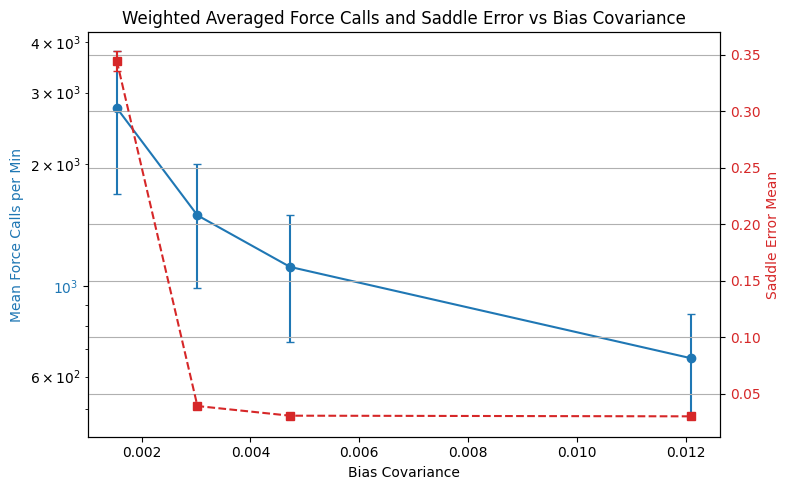

In [410]:
import numpy as np
import matplotlib.pyplot as plt

# Filter as before
contender_params = agg_df[
    (agg_df['num_minima_mean'] == 3) & 
    (agg_df['num_saddles_mean'] == 2)
]

def weighted_avg_and_sem(values, sems):
    values = np.array(values)
    sems = np.array(sems)
    variances = sems ** 2
    variances[variances == 0] = 1e-12
    weights = 1 / variances
    weighted_avg = np.sum(weights * values) / np.sum(weights)
    combined_sem = np.sqrt(1 / np.sum(weights))
    return weighted_avg, combined_sem

# Group by bias_covariance
grouped = []

for cov, group in contender_params.groupby('bias_covariance'):
    f_vals = group['mean_force_calls_per_min']
    f_sems = group['stdv_force_calls_per_min']
    s_vals = group['saddle_error_mean']
    s_sems = group['saddle_error_stderr']

    f_avg, f_sem = weighted_avg_and_sem(f_vals, f_sems)
    s_avg, s_sem = weighted_avg_and_sem(s_vals, s_sems)

    grouped.append({
        'bias_covariance': cov,
        'mean_force_calls_per_min': f_avg,
        'std_force_calls_per_min': f_sem,
        'mean_saddle_error': s_avg,
        'std_saddle_error': s_sem
    })

grouped_df = pd.DataFrame(grouped).sort_values('bias_covariance')

x = grouped_df['bias_covariance']
y1 = grouped_df['mean_force_calls_per_min']
y1_err = grouped_df['std_force_calls_per_min']

y2 = grouped_df['mean_saddle_error']
y2_err = grouped_df['std_saddle_error']

fig, ax1 = plt.subplots(figsize=(8,5))

color1 = 'tab:blue'
ax1.set_xlabel('Bias Covariance')
ax1.set_ylabel('Mean Force Calls per Min', color=color1)
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', color=color1, capsize=3)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_yscale('log')  # optional

ax2 = ax1.twinx()

color2 = 'tab:red'
ax2.set_ylabel('Saddle Error Mean', color=color2)
ax2.errorbar(x, y2, yerr=y2_err, fmt='s--', color=color2, capsize=3)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Weighted Averaged Force Calls and Saddle Error vs Bias Covariance')
plt.grid(True)
plt.tight_layout()
plt.show()


In [411]:
agg_df

,run_id,saddle_error_mean,saddle_error_stderr,minima_error_mean,minima_error_stderr,bias_count_mean,bias_count_stderr,num_minima_mean,num_minima_stderr,num_saddles_mean,...,mean_force_calls_per_min,stdv_force_calls_per_min,mean_energy_calls_per_min,stdv_energy_calls_per_min,bias_std_dev_scale,bias_covariance,bias_height_fraction,bias_height,perturbation_size,optimizer
40,120,0.375587,0.149124,1.672933e-05,1.179832e-05,69.666667,1.201850,3.0,0.0,2.0,...,3114.222222,3489.420395,3114.222222,3489.420395,0.200000,0.012100,0.200000,7.600000,0.1000,FIRE
41,123,0.366323,0.063022,7.141713e-05,4.292503e-05,41.666667,11.170397,3.0,0.0,2.0,...,354.111111,411.052139,354.111111,411.052139,0.200000,0.012100,0.200000,7.600000,0.1000,Scipy
42,126,0.051051,0.020125,1.672545e-05,1.179882e-05,61.000000,11.239810,3.0,0.0,2.0,...,2726.222222,3246.790445,2726.222222,3246.790445,0.200000,0.012100,0.200000,7.600000,0.0100,FIRE
43,129,0.210641,0.056160,1.540466e-05,1.236877e-05,30.000000,11.135529,3.0,0.0,2.0,...,422.666667,453.939148,422.666667,453.939148,0.200000,0.012100,0.200000,7.600000,0.0100,Scipy
44,132,0.127614,0.072425,1.954561e-05,1.175912e-05,55.333333,13.568755,3.0,0.0,2.0,...,2568.444444,2975.080592,2568.444444,2975.080592,0.200000,0.012100,0.200000,7.600000,0.0010,FIRE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,543,0.313591,0.029429,5.496490e-09,2.052037e-10,1340.333333,99.153641,3.0,0.0,2.0,...,20579.888889,28649.386278,20579.888889,28649.386278,0.071429,0.001543,0.033333,1.266667,0.0010,Scipy
183,549,0.270906,0.021116,5.548886e-09,1.673634e-10,1376.333333,174.938402,3.0,0.0,2.0,...,23383.555556,31040.914758,23383.555556,31040.914758,0.071429,0.001543,0.033333,1.266667,0.0001,Scipy
185,555,0.680642,0.112429,5.356345e-09,2.119807e-10,907.000000,536.646066,3.0,0.0,2.0,...,11583.777778,19961.844822,11583.777778,19961.844822,0.071429,0.001543,0.020000,0.760000,0.1000,Scipy
187,561,0.244405,0.042491,5.356345e-09,2.119807e-10,424.666667,15.059143,3.0,0.0,2.0,...,6879.444444,9117.942697,6879.444444,9117.942697,0.071429,0.001543,0.020000,0.760000,0.0100,Scipy


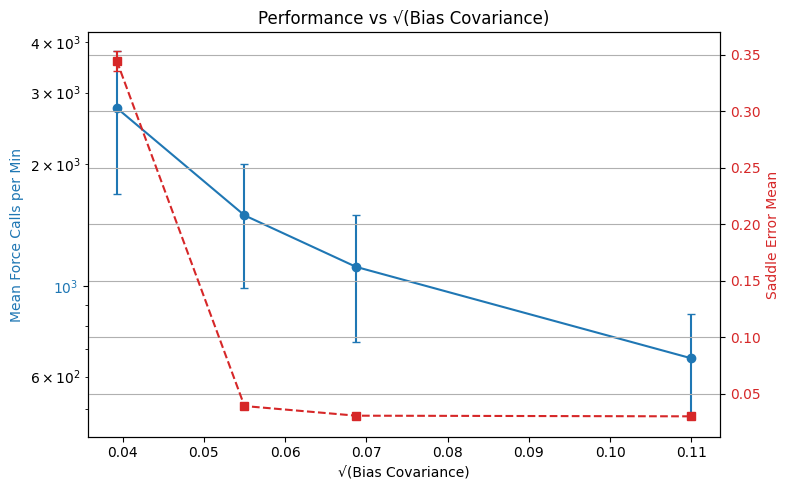

In [432]:
import numpy as np
import matplotlib.pyplot as plt

# --- Filter to only runs with exactly 3 minima and 2 saddles ---
contender_params = agg_df[
    (agg_df['num_minima_mean'] == 3) & 
    (agg_df['num_saddles_mean'] == 2)
]

# --- Helper: Weighted average + SEM ---
def weighted_avg_and_sem(values, sems):
    values = np.array(values)
    sems = np.array(sems)
    variances = sems ** 2
    variances[variances == 0] = 1e-12
    weights = 1 / variances
    weighted_avg = np.sum(weights * values) / np.sum(weights)
    combined_sem = np.sqrt(1 / np.sum(weights))
    return weighted_avg, combined_sem

# --- Group by bias_covariance ---
grouped = []

for cov, group in contender_params.groupby('bias_covariance'):
    f_vals = group['mean_force_calls_per_min']
    f_sems = group['stdv_force_calls_per_min']
    s_vals = group['saddle_error_mean']
    s_sems = group['saddle_error_stderr']

    f_avg, f_sem = weighted_avg_and_sem(f_vals, f_sems)
    s_avg, s_sem = weighted_avg_and_sem(s_vals, s_sems)

    grouped.append({
        'sqrt_bias_covariance': np.sqrt(cov),
        'mean_force_calls_per_min': f_avg,
        'std_force_calls_per_min': f_sem,
        'mean_saddle_error': s_avg,
        'std_saddle_error': s_sem
    })

# --- Convert to DataFrame and sort by x-axis ---
grouped_df = pd.DataFrame(grouped).sort_values('sqrt_bias_covariance')

x = grouped_df['sqrt_bias_covariance']
y1 = grouped_df['mean_force_calls_per_min']
y1_err = grouped_df['std_force_calls_per_min']

y2 = grouped_df['mean_saddle_error']
y2_err = grouped_df['std_saddle_error']

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('√(Bias Covariance)')
ax1.set_ylabel('Mean Force Calls per Min', color=color1)
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', color=color1, capsize=3)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_yscale('log')  # optional

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Saddle Error Mean', color=color2)
ax2.errorbar(x, y2, yerr=y2_err, fmt='s--', color=color2, capsize=3)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Performance vs √(Bias Covariance)')
plt.grid(True)
plt.tight_layout()
plt.show()


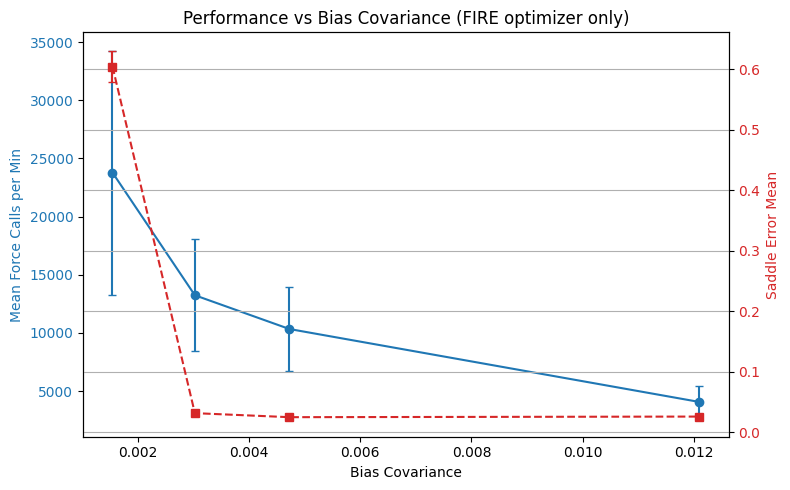

In [412]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Filter to "FIRE" optimizer with complete minima/saddle coverage
contender_params = agg_df[
    (agg_df['optimizer'] == 'FIRE') &
    (agg_df['num_minima_mean'] == 3) &
    (agg_df['num_saddles_mean'] == 2)
].copy()

# Step 2: Helper for weighted mean and SEM
def weighted_avg_and_sem(values, sems):
    values = np.asarray(values, dtype=float)
    sems = np.asarray(sems, dtype=float)

    # Handle any 0 or nan SEMs safely
    sems[sems <= 0] = 1e-12
    valid = ~np.isnan(values) & ~np.isnan(sems)
    if valid.sum() == 0:
        return np.nan, np.nan

    weights = 1 / sems[valid]**2
    weighted_avg = np.sum(weights * values[valid]) / np.sum(weights)
    combined_sem = np.sqrt(1 / np.sum(weights))
    return weighted_avg, combined_sem

# Step 3: Group by bias_covariance (scalar)
grouped_data = []
for cov, group in contender_params.groupby('bias_covariance'):
    f_avg, f_sem = weighted_avg_and_sem(group['mean_force_calls_per_min'], group['stdv_force_calls_per_min'])
    s_avg, s_sem = weighted_avg_and_sem(group['saddle_error_mean'], group['saddle_error_stderr'])

    grouped_data.append({
        'bias_covariance': cov,
        'mean_force_calls_per_min': f_avg,
        'std_force_calls_per_min': f_sem,
        'mean_saddle_error': s_avg,
        'std_saddle_error': s_sem
    })

grouped_df = pd.DataFrame(grouped_data)

# Step 4: Sort by bias_covariance
grouped_df.sort_values('bias_covariance', inplace=True)

# Step 5: Plot
x = grouped_df['bias_covariance']
y1 = grouped_df['mean_force_calls_per_min']
y1_err = grouped_df['std_force_calls_per_min']
y2 = grouped_df['mean_saddle_error']
y2_err = grouped_df['std_saddle_error']

fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Bias Covariance')
ax1.set_ylabel('Mean Force Calls per Min', color=color1)
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', color=color1, capsize=3, label='Force Calls')
ax1.tick_params(axis='y', labelcolor=color1)
# ax1.set_yscale('log')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Saddle Error Mean', color=color2)
ax2.errorbar(x, y2, yerr=y2_err, fmt='s--', color=color2, capsize=3, label='Saddle Error')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Performance vs Bias Covariance (FIRE optimizer only)")
plt.grid(True)
plt.tight_layout()
plt.show()


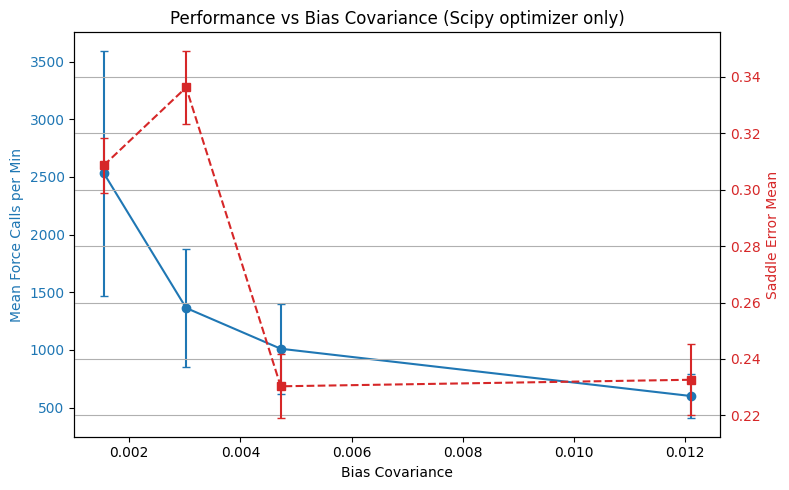

In [413]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Filter to "FIRE" optimizer with complete minima/saddle coverage
contender_params = agg_df[
    (agg_df['optimizer'] == 'Scipy') &
    (agg_df['num_minima_mean'] == 3) &
    (agg_df['num_saddles_mean'] == 2)
].copy()

# Step 2: Helper for weighted mean and SEM
def weighted_avg_and_sem(values, sems):
    values = np.asarray(values, dtype=float)
    sems = np.asarray(sems, dtype=float)

    # Handle any 0 or nan SEMs safely
    sems[sems <= 0] = 1e-12
    valid = ~np.isnan(values) & ~np.isnan(sems)
    if valid.sum() == 0:
        return np.nan, np.nan

    weights = 1 / sems[valid]**2
    weighted_avg = np.sum(weights * values[valid]) / np.sum(weights)
    combined_sem = np.sqrt(1 / np.sum(weights))
    return weighted_avg, combined_sem

# Step 3: Group by bias_covariance (scalar)
grouped_data = []
for cov, group in contender_params.groupby('bias_covariance'):
    f_avg, f_sem = weighted_avg_and_sem(group['mean_force_calls_per_min'], group['stdv_force_calls_per_min'])
    s_avg, s_sem = weighted_avg_and_sem(group['saddle_error_mean'], group['saddle_error_stderr'])

    grouped_data.append({
        'bias_covariance': cov,
        'mean_force_calls_per_min': f_avg,
        'std_force_calls_per_min': f_sem,
        'mean_saddle_error': s_avg,
        'std_saddle_error': s_sem
    })

grouped_df = pd.DataFrame(grouped_data)

# Step 4: Sort by bias_covariance
grouped_df.sort_values('bias_covariance', inplace=True)

# Step 5: Plot
x = grouped_df['bias_covariance']
y1 = grouped_df['mean_force_calls_per_min']
y1_err = grouped_df['std_force_calls_per_min']
y2 = grouped_df['mean_saddle_error']
y2_err = grouped_df['std_saddle_error']

fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Bias Covariance')
ax1.set_ylabel('Mean Force Calls per Min', color=color1)
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', color=color1, capsize=3, label='Force Calls')
ax1.tick_params(axis='y', labelcolor=color1)
# ax1.set_yscale('log')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Saddle Error Mean', color=color2)
ax2.errorbar(x, y2, yerr=y2_err, fmt='s--', color=color2, capsize=3, label='Saddle Error')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Performance vs Bias Covariance (Scipy optimizer only)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [414]:
agg_df =  agg_df[
    (agg_df['num_minima_mean'] == 3) & 
    (agg_df['num_saddles_mean'] == 2)
]

Found 32 runs with bias_height_fraction == 0.1


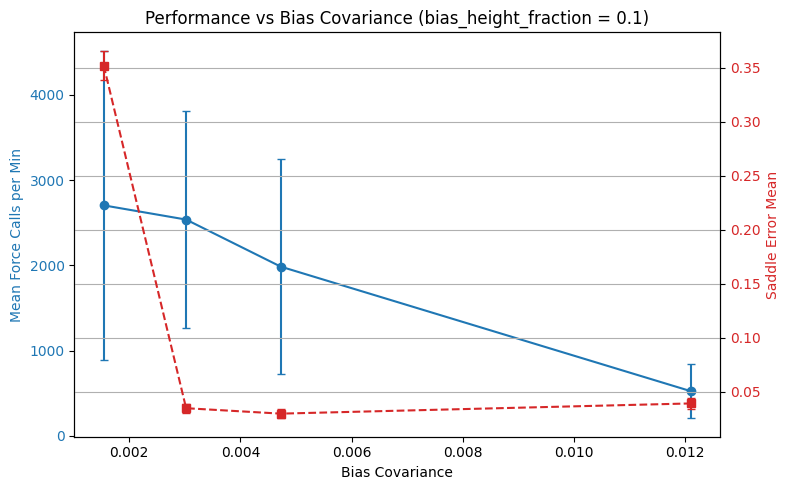

In [415]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ✅ Filter to just the bias height fraction you care about
subset = agg_df[agg_df['bias_height_fraction'] == 0.1].copy()

print(f"Found {len(subset)} runs with bias_height_fraction == 0.1")

# ✅ Weighted avg + SEM helper
def weighted_avg_and_sem(values, sems):
    values = np.asarray(values, dtype=float)
    sems = np.asarray(sems, dtype=float)
    
    # Handle nan/zero sems
    sems[sems <= 0] = 1e-12
    valid = ~np.isnan(values) & ~np.isnan(sems)
    if valid.sum() == 0:
        return np.nan, np.nan
    
    weights = 1 / sems[valid]**2
    weighted_avg = np.sum(weights * values[valid]) / np.sum(weights)
    combined_sem = np.sqrt(1 / np.sum(weights))
    return weighted_avg, combined_sem

# ✅ Group by bias covariance
grouped = []
for cov, group in subset.groupby('bias_covariance'):
    f_avg, f_sem = weighted_avg_and_sem(group['mean_force_calls_per_min'], group['stdv_force_calls_per_min'])
    s_avg, s_sem = weighted_avg_and_sem(group['saddle_error_mean'], group['saddle_error_stderr'])

    grouped.append({
        'bias_covariance': cov,
        'mean_force_calls_per_min': f_avg,
        'std_force_calls_per_min': f_sem,
        'mean_saddle_error': s_avg,
        'std_saddle_error': s_sem
    })

grouped_df = pd.DataFrame(grouped).sort_values('bias_covariance')

# ✅ Plotting
x = grouped_df['bias_covariance']
y1 = grouped_df['mean_force_calls_per_min']
y1_err = grouped_df['std_force_calls_per_min']
y2 = grouped_df['mean_saddle_error']
y2_err = grouped_df['std_saddle_error']

fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Bias Covariance')
ax1.set_ylabel('Mean Force Calls per Min', color=color1)
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', color=color1, capsize=3)
ax1.tick_params(axis='y', labelcolor=color1)
# ax1.set_yscale('log')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Saddle Error Mean', color=color2)
ax2.errorbar(x, y2, yerr=y2_err, fmt='s--', color=color2, capsize=3)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Performance vs Bias Covariance (bias_height_fraction = 0.1)")
plt.grid(True)
plt.tight_layout()
plt.show()


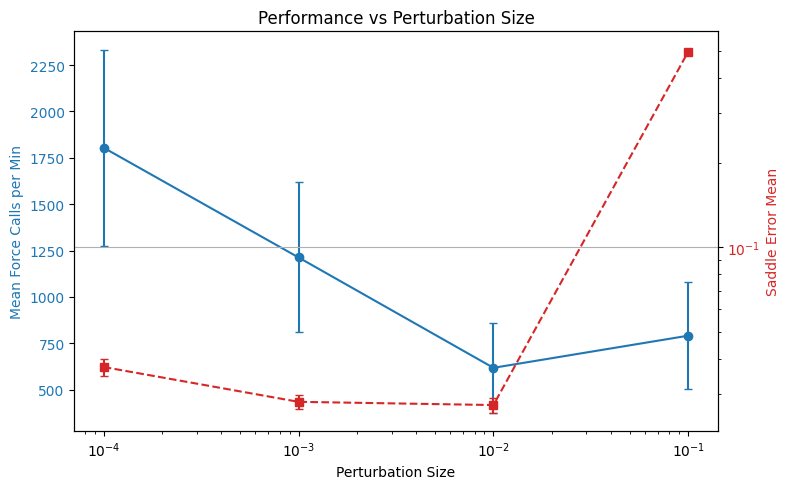

In [431]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Helper function ---
def weighted_avg_and_sem(values, sems):
    values = np.asarray(values, dtype=float)
    sems = np.asarray(sems, dtype=float)

    sems[sems <= 0] = 1e-12
    valid = ~np.isnan(values) & ~np.isnan(sems)
    if valid.sum() == 0:
        return np.nan, np.nan

    weights = 1 / sems[valid]**2
    weighted_avg = np.sum(weights * values[valid]) / np.sum(weights)
    combined_sem = np.sqrt(1 / np.sum(weights))
    return weighted_avg, combined_sem

# --- Group by perturbation size ---
grouped = []
for psize, group in agg_df.groupby('perturbation_size'):
    f_avg, f_sem = weighted_avg_and_sem(group['mean_force_calls_per_min'], group['stdv_force_calls_per_min'])
    s_avg, s_sem = weighted_avg_and_sem(group['saddle_error_mean'], group['saddle_error_stderr'])

    grouped.append({
        'perturbation_size': psize,
        'mean_force_calls_per_min': f_avg,
        'std_force_calls_per_min': f_sem,
        'mean_saddle_error': s_avg,
        'std_saddle_error': s_sem
    })

grouped_df = pd.DataFrame(grouped).sort_values('perturbation_size')

# --- Plot ---
x = grouped_df['perturbation_size']
y1 = grouped_df['mean_force_calls_per_min']
y1_err = grouped_df['std_force_calls_per_min']
y2 = grouped_df['mean_saddle_error']
y2_err = grouped_df['std_saddle_error']

fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Perturbation Size')
ax1.set_ylabel('Mean Force Calls per Min', color=color1)
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', color=color1, capsize=3)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xscale('log')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Saddle Error Mean', color=color2)
ax2.errorbar(x, y2, yerr=y2_err, fmt='s--', color=color2, capsize=3)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_yscale('log')

plt.title("Performance vs Perturbation Size")
plt.grid(True)
plt.tight_layout()
plt.show()


Using 32 runs with bias_height_fraction == 0.1


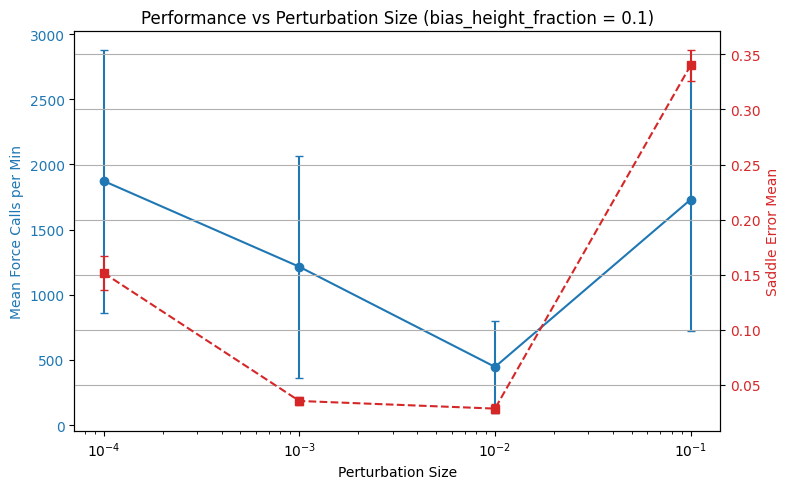

In [417]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Filter first ---
subset = agg_df[agg_df['bias_height_fraction'] == 0.1].copy()
print(f"Using {len(subset)} runs with bias_height_fraction == 0.1")

# --- Helper: Weighted average + SEM ---
def weighted_avg_and_sem(values, sems):
    values = np.asarray(values, dtype=float)
    sems = np.asarray(sems, dtype=float)

    sems[sems <= 0] = 1e-12
    valid = ~np.isnan(values) & ~np.isnan(sems)
    if valid.sum() == 0:
        return np.nan, np.nan

    weights = 1 / sems[valid]**2
    weighted_avg = np.sum(weights * values[valid]) / np.sum(weights)
    combined_sem = np.sqrt(1 / np.sum(weights))
    return weighted_avg, combined_sem

# --- Group by perturbation_size ---
grouped = []
for psize, group in subset.groupby('perturbation_size'):
    f_avg, f_sem = weighted_avg_and_sem(group['mean_force_calls_per_min'], group['stdv_force_calls_per_min'])
    s_avg, s_sem = weighted_avg_and_sem(group['saddle_error_mean'], group['saddle_error_stderr'])

    grouped.append({
        'perturbation_size': psize,
        'mean_force_calls_per_min': f_avg,
        'std_force_calls_per_min': f_sem,
        'mean_saddle_error': s_avg,
        'std_saddle_error': s_sem
    })

grouped_df = pd.DataFrame(grouped).sort_values('perturbation_size')

# --- Plot ---
x = grouped_df['perturbation_size']
y1 = grouped_df['mean_force_calls_per_min']
y1_err = grouped_df['std_force_calls_per_min']
y2 = grouped_df['mean_saddle_error']
y2_err = grouped_df['std_saddle_error']

fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Perturbation Size')
ax1.set_ylabel('Mean Force Calls per Min', color=color1)
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', color=color1, capsize=3)
ax1.tick_params(axis='y', labelcolor=color1)
# ax1.set_yscale('log')
ax1.set_xscale('log')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Saddle Error Mean', color=color2)
ax2.errorbar(x, y2, yerr=y2_err, fmt='s--', color=color2, capsize=3)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Performance vs Perturbation Size (bias_height_fraction = 0.1)")
plt.grid(True)
plt.tight_layout()
plt.show()


Using 32 runs with bias_height_fraction == 0.1


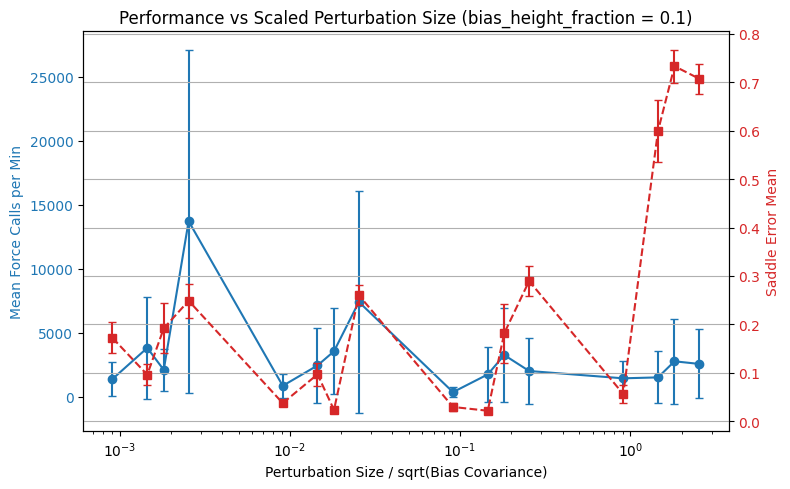

In [418]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Filter by bias_height_fraction ---
subset = agg_df[agg_df['bias_height_fraction'] == 0.1].copy()
# subset = agg_df
print(f"Using {len(subset)} runs with bias_height_fraction == 0.1")

# Compute new x-axis quantity: perturbation_size / sqrt(bias_covariance)
subset = subset[subset['bias_covariance'] > 0]  # avoid division by zero or negative covariance
subset['scaled_perturbation'] = subset['perturbation_size'] / np.sqrt(subset['bias_covariance'])

# --- Weighted avg + SEM helper ---
def weighted_avg_and_sem(values, sems):
    values = np.asarray(values, dtype=float)
    sems = np.asarray(sems, dtype=float)
    sems[sems <= 0] = 1e-12
    valid = ~np.isnan(values) & ~np.isnan(sems)
    if valid.sum() == 0:
        return np.nan, np.nan
    weights = 1 / sems[valid]**2
    weighted_avg = np.sum(weights * values[valid]) / np.sum(weights)
    combined_sem = np.sqrt(1 / np.sum(weights))
    return weighted_avg, combined_sem

# --- Group by scaled_perturbation ---
grouped = []
for val, group in subset.groupby('scaled_perturbation'):
    f_avg, f_sem = weighted_avg_and_sem(group['mean_force_calls_per_min'], group['stdv_force_calls_per_min'])
    s_avg, s_sem = weighted_avg_and_sem(group['saddle_error_mean'], group['saddle_error_stderr'])
    
    grouped.append({
        'scaled_perturbation': val,
        'mean_force_calls_per_min': f_avg,
        'std_force_calls_per_min': f_sem,
        'mean_saddle_error': s_avg,
        'std_saddle_error': s_sem
    })

grouped_df = pd.DataFrame(grouped).sort_values('scaled_perturbation')

# --- Plot ---
x = grouped_df['scaled_perturbation']
y1 = grouped_df['mean_force_calls_per_min']
y1_err = grouped_df['std_force_calls_per_min']
y2 = grouped_df['mean_saddle_error']
y2_err = grouped_df['std_saddle_error']

fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Perturbation Size / sqrt(Bias Covariance)')
ax1.set_ylabel('Mean Force Calls per Min', color=color1)
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', color=color1, capsize=3)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xscale('log')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Saddle Error Mean', color=color2)
ax2.errorbar(x, y2, yerr=y2_err, fmt='s--', color=color2, capsize=3)
ax2.tick_params(axis='y', labelcolor=color2)
# ax2.set_yscale('log')

plt.title("Performance vs Scaled Perturbation Size (bias_height_fraction = 0.1)")
plt.grid(True)
plt.tight_layout()
plt.show()


Using 32 runs with bias_height_fraction == 0.1


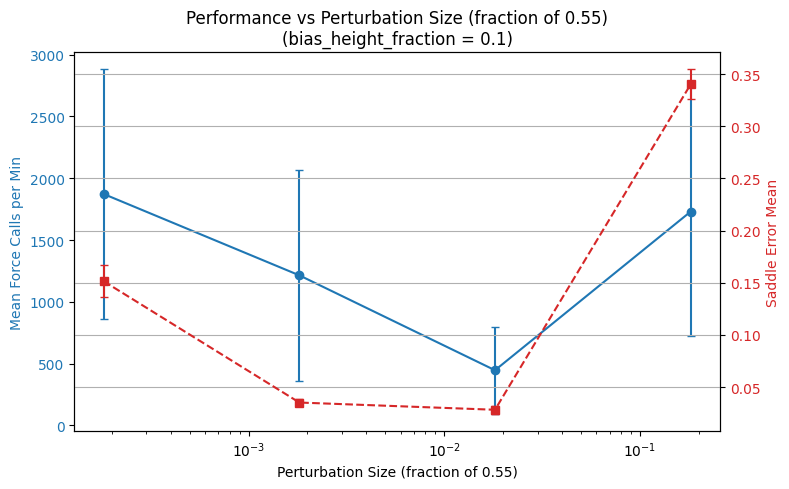

In [419]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Filter first ---
subset = agg_df[agg_df['bias_height_fraction'] == 0.1].copy()
print(f"Using {len(subset)} runs with bias_height_fraction == 0.1")

# --- Helper: Weighted average + SEM ---
def weighted_avg_and_sem(values, sems):
    values = np.asarray(values, dtype=float)
    sems = np.asarray(sems, dtype=float)

    sems[sems <= 0] = 1e-12
    valid = ~np.isnan(values) & ~np.isnan(sems)
    if valid.sum() == 0:
        return np.nan, np.nan

    weights = 1 / sems[valid]**2
    weighted_avg = np.sum(weights * values[valid]) / np.sum(weights)
    combined_sem = np.sqrt(1 / np.sum(weights))
    return weighted_avg, combined_sem

# --- Group by perturbation_size ---
grouped = []
for psize, group in subset.groupby('perturbation_size'):
    f_avg, f_sem = weighted_avg_and_sem(group['mean_force_calls_per_min'], group['stdv_force_calls_per_min'])
    s_avg, s_sem = weighted_avg_and_sem(group['saddle_error_mean'], group['saddle_error_stderr'])

    grouped.append({
        'perturbation_size': psize / 0.55,  # <-- scale here by dividing by 0.55
        'mean_force_calls_per_min': f_avg,
        'std_force_calls_per_min': f_sem,
        'mean_saddle_error': s_avg,
        'std_saddle_error': s_sem
    })

grouped_df = pd.DataFrame(grouped).sort_values('perturbation_size')

# --- Plot ---
x = grouped_df['perturbation_size']
y1 = grouped_df['mean_force_calls_per_min']
y1_err = grouped_df['std_force_calls_per_min']
y2 = grouped_df['mean_saddle_error']
y2_err = grouped_df['std_saddle_error']

fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Perturbation Size (fraction of 0.55)')
ax1.set_ylabel('Mean Force Calls per Min', color=color1)
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', color=color1, capsize=3)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xscale('log')  # optional

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Saddle Error Mean', color=color2)
ax2.errorbar(x, y2, yerr=y2_err, fmt='s--', color=color2, capsize=3)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Performance vs Perturbation Size (fraction of 0.55)\n(bias_height_fraction = 0.1)")
plt.grid(True)
plt.tight_layout()
plt.show()


Number of runs matching conditions: 8


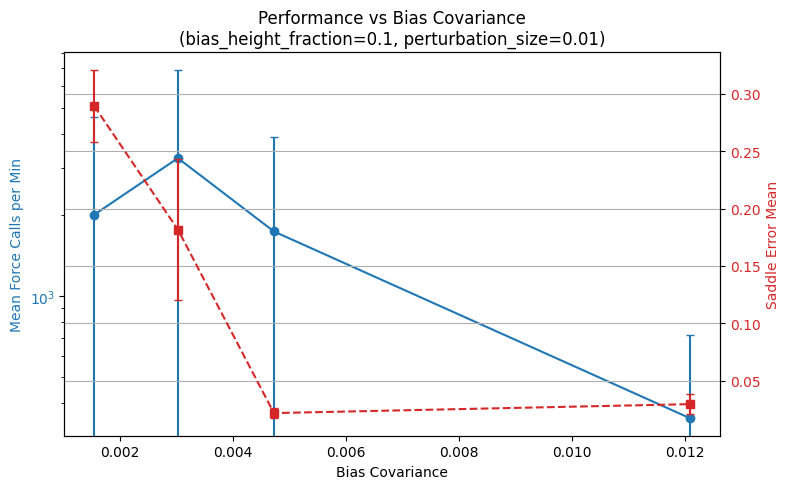

In [420]:
import numpy as np
import matplotlib.pyplot as plt

# Filter for given conditions
subset = agg_df[
    (agg_df['bias_height_fraction'] == 0.1) &
    (agg_df['perturbation_size'] == 0.01)
].copy()

print(f"Number of runs matching conditions: {len(subset)}")

# Weighted avg + SEM helper
def weighted_avg_and_sem(values, sems):
    values = np.asarray(values, dtype=float)
    sems = np.asarray(sems, dtype=float)
    sems[sems <= 0] = 1e-12
    valid = ~np.isnan(values) & ~np.isnan(sems)
    if valid.sum() == 0:
        return np.nan, np.nan
    weights = 1 / sems[valid]**2
    weighted_avg = np.sum(weights * values[valid]) / np.sum(weights)
    combined_sem = np.sqrt(1 / np.sum(weights))
    return weighted_avg, combined_sem

# Group by bias_covariance
grouped = []
for cov, group in subset.groupby('bias_covariance'):
    f_avg, f_sem = weighted_avg_and_sem(group['mean_force_calls_per_min'], group['stdv_force_calls_per_min'])
    s_avg, s_sem = weighted_avg_and_sem(group['saddle_error_mean'], group['saddle_error_stderr'])
    
    grouped.append({
        'bias_covariance': cov,
        'mean_force_calls_per_min': f_avg,
        'std_force_calls_per_min': f_sem,
        'mean_saddle_error': s_avg,
        'std_saddle_error': s_sem
    })

grouped_df = pd.DataFrame(grouped).sort_values('bias_covariance')

# Plot
x = grouped_df['bias_covariance']
y1 = grouped_df['mean_force_calls_per_min']
y1_err = grouped_df['std_force_calls_per_min']
y2 = grouped_df['mean_saddle_error']
y2_err = grouped_df['std_saddle_error']

fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Bias Covariance')
ax1.set_ylabel('Mean Force Calls per Min', color=color1)
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', color=color1, capsize=3)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_yscale('log')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Saddle Error Mean', color=color2)
ax2.errorbar(x, y2, yerr=y2_err, fmt='s--', color=color2, capsize=3)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Performance vs Bias Covariance\n(bias_height_fraction=0.1, perturbation_size=0.01)")
plt.grid(True)
plt.tight_layout()
plt.show()


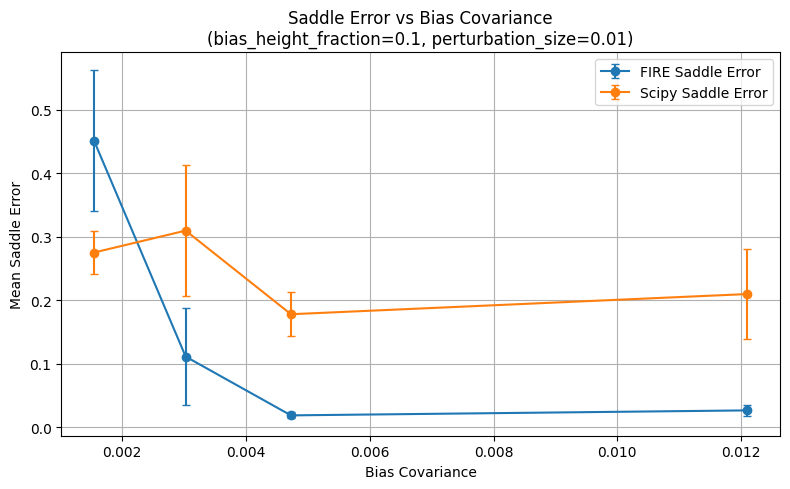

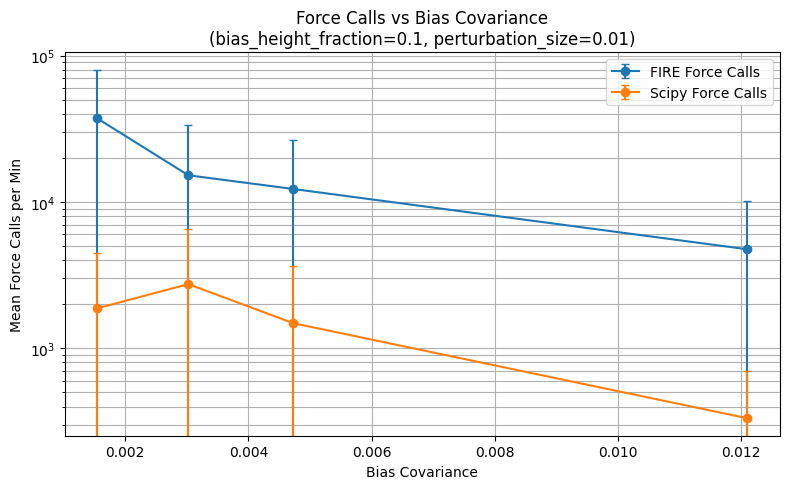

In [421]:
import numpy as np
import matplotlib.pyplot as plt

# First, standardize optimizer strings in the DataFrame
agg_df['optimizer'] = agg_df['optimizer'].str.capitalize()
agg_df['optimizer'] = agg_df['optimizer'].replace({'Fire': 'FIRE', 'Scipy': 'Scipy'})

# Filter relevant runs with the corrected capitalization
subset = agg_df[
    (agg_df['bias_height_fraction'] == 0.1) &
    (agg_df['perturbation_size'] == 0.01) &
    (agg_df['optimizer'].isin(['FIRE', 'Scipy']))
].copy()

def weighted_avg_and_sem(values, sems):
    values = np.asarray(values, dtype=float)
    sems = np.asarray(sems, dtype=float)
    sems[sems <= 0] = 1e-12
    valid = ~np.isnan(values) & ~np.isnan(sems)
    if valid.sum() == 0:
        return np.nan, np.nan
    weights = 1 / sems[valid]**2
    weighted_avg = np.sum(weights * values[valid]) / np.sum(weights)
    combined_sem = np.sqrt(1 / np.sum(weights))
    return weighted_avg, combined_sem

# Group data by optimizer and bias_covariance
grouped_data = {}
for optimizer in ['FIRE', 'Scipy']:
    grouped = []
    opt_group = subset[subset['optimizer'] == optimizer]
    for cov, group in opt_group.groupby('bias_covariance'):
        f_avg, f_sem = weighted_avg_and_sem(group['mean_force_calls_per_min'], group['stdv_force_calls_per_min'])
        s_avg, s_sem = weighted_avg_and_sem(group['saddle_error_mean'], group['saddle_error_stderr'])
        grouped.append({
            'bias_covariance': cov,
            'mean_force_calls_per_min': f_avg,
            'std_force_calls_per_min': f_sem,
            'saddle_error_mean': s_avg,
            'std_saddle_error': s_sem
        })
    grouped_data[optimizer] = pd.DataFrame(grouped).sort_values('bias_covariance')

colors = {
    'FIRE': 'tab:blue',
    'Scipy': 'tab:orange'
}

# Plot 1: Saddle Error vs Bias Covariance
plt.figure(figsize=(8,5))
for optimizer in ['FIRE', 'Scipy']:
    df = grouped_data[optimizer]
    plt.errorbar(df['bias_covariance'], df['saddle_error_mean'], yerr=df['std_saddle_error'],
                 fmt='o-', color=colors[optimizer], capsize=3,
                 label=f"{optimizer} Saddle Error")
plt.xlabel('Bias Covariance')
plt.ylabel('Mean Saddle Error')
plt.title('Saddle Error vs Bias Covariance\n(bias_height_fraction=0.1, perturbation_size=0.01)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Mean Force Calls per Min vs Bias Covariance (log scale)
plt.figure(figsize=(8,5))
for optimizer in ['FIRE', 'Scipy']:
    df = grouped_data[optimizer]
    plt.errorbar(df['bias_covariance'], df['mean_force_calls_per_min'], yerr=df['std_force_calls_per_min'],
                 fmt='o-', color=colors[optimizer], capsize=3,
                 label=f"{optimizer} Force Calls")
plt.xlabel('Bias Covariance')
plt.ylabel('Mean Force Calls per Min')
plt.title('Force Calls vs Bias Covariance\n(bias_height_fraction=0.1, perturbation_size=0.01)')
plt.yscale('log')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()


In [422]:
agg_df.columns

Index(['run_id', 'saddle_error_mean', 'saddle_error_stderr',
       'minima_error_mean', 'minima_error_stderr', 'bias_count_mean',
       'bias_count_stderr', 'num_minima_mean', 'num_minima_stderr',
       'num_saddles_mean', 'num_saddles_stderr', 'energy_calls_mean',
       'energy_calls_stderr', 'force_calls_mean', 'force_calls_stderr',
       'mean_force_calls_per_min', 'stdv_force_calls_per_min',
       'mean_energy_calls_per_min', 'stdv_energy_calls_per_min',
       'bias_std_dev_scale', 'bias_covariance', 'bias_height_fraction',
       'bias_height', 'perturbation_size', 'optimizer'],
      dtype='object')

In [466]:
import numpy as np

def min_max_norm(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

errors = agg_df['saddle_error_mean'].values
calls = agg_df['mean_force_calls_per_min'].values

errors_norm = min_max_norm(errors)
calls_norm = min_max_norm(calls)

combined_score = errors_norm + calls_norm  # simple sum

agg_df = agg_df.copy()
agg_df['combined_score'] = combined_score

agg_df_sorted = agg_df.sort_values('combined_score', ascending=True)

(agg_df_sorted[['saddle_error_mean', 'mean_force_calls_per_min', 'combined_score']].head(10))

,saddle_error_mean,mean_force_calls_per_min,combined_score
50,0.026858,4749.111111,0.066987
42,0.051051,2726.222222,0.075307
52,0.034662,5604.666667,0.086411
48,0.046684,5064.111111,0.095704
90,0.019012,12271.888889,0.140511
58,0.024575,12725.444444,0.152622
44,0.127614,2568.444444,0.170948
62,0.027804,14314.000000,0.174364
132,0.022267,15153.777778,0.176642
54,0.099843,6287.555556,0.176905


In [424]:
agg_df_sorted.iloc[0]

run_id                                                                150
saddle_error_mean                                                0.026858
saddle_error_stderr                                               0.00848
minima_error_mean                                                0.000106
minima_error_stderr                                              0.000086
bias_count_mean                                                105.666667
bias_count_stderr                                               21.168635
num_minima_mean                                                       3.0
num_minima_stderr                                                     0.0
num_saddles_mean                                                      2.0
num_saddles_stderr                                                    0.0
energy_calls_mean                    [104.0, 3115.3333333333335, 11028.0]
energy_calls_stderr          [0.0, 133.66167904244074, 2826.118244754337]
force_calls_mean                     [

In [425]:
agg_df_sorted[agg_df_sorted['optimizer'] != 'FIRE'].iloc[0]

run_id                                                                  351
saddle_error_mean                                                  0.115624
saddle_error_stderr                                                0.038836
minima_error_mean                                                       0.0
minima_error_stderr                                                     0.0
bias_count_mean                                                  497.333333
bias_count_stderr                                                 48.936467
num_minima_mean                                                         3.0
num_minima_stderr                                                       0.0
num_saddles_mean                                                        2.0
num_saddles_stderr                                                      0.0
energy_calls_mean            [13.0, 13086.666666666666, 3233.6666666666665]
energy_calls_stderr             [0.0, 1480.2136482428625, 1775.17147841491]
force_calls_

In [426]:
agg_df_sorted_by_force_calls = agg_df.sort_values('mean_force_calls_per_min', ascending=True)

# Fastest run
agg_df_sorted_by_force_calls.iloc[0]

run_id                                                                 153
saddle_error_mean                                                 0.209876
saddle_error_stderr                                                0.07024
minima_error_mean                                                 0.000045
minima_error_stderr                                                0.00004
bias_count_mean                                                  33.666667
bias_count_stderr                                                 2.333333
num_minima_mean                                                        3.0
num_minima_stderr                                                      0.0
num_saddles_mean                                                       2.0
num_saddles_stderr                                                     0.0
energy_calls_mean            [13.0, 804.6666666666666, 179.33333333333334]
energy_calls_stderr            [0.0, 32.76346203386395, 38.09782729296311]
force_calls_mean         

In [461]:
# Fastest FIRE run
agg_df_sorted_by_force_calls.iloc[41]

run_id                                                                 138
saddle_error_mean                                                 0.166044
saddle_error_stderr                                               0.071704
minima_error_mean                                                 0.000012
minima_error_stderr                                                0.00001
bias_count_mean                                                  65.666667
bias_count_stderr                                                 9.871395
num_minima_mean                                                        3.0
num_minima_stderr                                                      0.0
num_saddles_mean                                                       2.0
num_saddles_stderr                                                     0.0
energy_calls_mean                       [104.0, 1875.0, 7226.333333333333]
energy_calls_stderr          [0.0, 126.15995138447595, 1400.5884874263072]
force_calls_mean         

In [452]:
agg_df_sorted_by_accuracy = agg_df.sort_values('saddle_error_mean', ascending=True)

# most accurate run
agg_df_sorted_by_accuracy.iloc[0]

run_id                                                               444
saddle_error_mean                                               0.012739
saddle_error_stderr                                             0.004513
minima_error_mean                                                    0.0
minima_error_stderr                                                  0.0
bias_count_mean                                                   1794.0
bias_count_stderr                                              62.481997
num_minima_mean                                                      3.0
num_minima_stderr                                                    0.0
num_saddles_mean                                                     2.0
num_saddles_stderr                                                   0.0
energy_calls_mean                  [104.0, 39270.333333333336, 218824.0]
energy_calls_stderr          [0.0, 397.6859453276054, 9018.075755577425]
force_calls_mean                   [104.0, 39270.33

In [453]:
# Most accurate Scipy run 
agg_df_sorted_by_accuracy.iloc[33]

run_id                                                                  351
saddle_error_mean                                                  0.115624
saddle_error_stderr                                                0.038836
minima_error_mean                                                       0.0
minima_error_stderr                                                     0.0
bias_count_mean                                                  497.333333
bias_count_stderr                                                 48.936467
num_minima_mean                                                         3.0
num_minima_stderr                                                       0.0
num_saddles_mean                                                        2.0
num_saddles_stderr                                                      0.0
energy_calls_mean            [13.0, 13086.666666666666, 3233.6666666666665]
energy_calls_stderr             [0.0, 1480.2136482428625, 1775.17147841491]
force_calls_

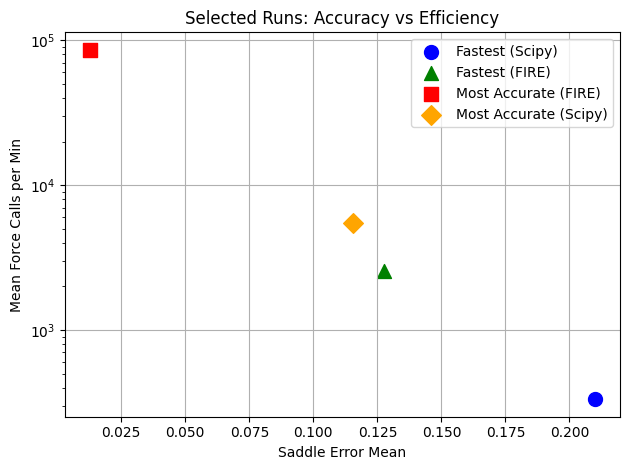

In [464]:
# Let's plot these 4 runs on a graph of force calls vs accuracy
import matplotlib.pyplot as plt

# --- Extract the 4 key runs ---
# Fastest overall
fastest = agg_df_sorted_by_force_calls.iloc[0]
# Fastest FIRE
fastest_fire = agg_df_sorted_by_force_calls[agg_df_sorted_by_force_calls['optimizer'] == 'FIRE'].iloc[0]

# Most accurate overall
most_accurate = agg_df_sorted_by_accuracy.iloc[0]
# Most accurate Scipy
most_accurate_scipy = agg_df_sorted_by_accuracy[agg_df_sorted_by_accuracy['optimizer'] == 'Scipy'].iloc[0]

# --- Prepare plot data ---
points = [
    {
        'label': 'Fastest (Scipy)',
        'x': fastest['saddle_error_mean'],
        'y': fastest['mean_force_calls_per_min'],
        'color': 'blue',
        'marker': 'o'
    },
    {
        'label': 'Fastest (FIRE)',
        'x': fastest_fire['saddle_error_mean'],
        'y': fastest_fire['mean_force_calls_per_min'],
        'color': 'green',
        'marker': '^'
    },
    {
        'label': 'Most Accurate (FIRE)',
        'x': most_accurate['saddle_error_mean'],
        'y': most_accurate['mean_force_calls_per_min'],
        'color': 'red',
        'marker': 's'
    },
    {
        'label': 'Most Accurate (Scipy)',
        'x': most_accurate_scipy['saddle_error_mean'],
        'y': most_accurate_scipy['mean_force_calls_per_min'],
        'color': 'orange',
        'marker': 'D'
    }
]

# --- Plot ---
for p in points:
    plt.scatter(p['x'], p['y'], label=p['label'], color=p['color'], marker=p['marker'], s=100)

plt.xlabel('Saddle Error Mean')
plt.ylabel('Mean Force Calls per Min')
plt.title('Selected Runs: Accuracy vs Efficiency')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


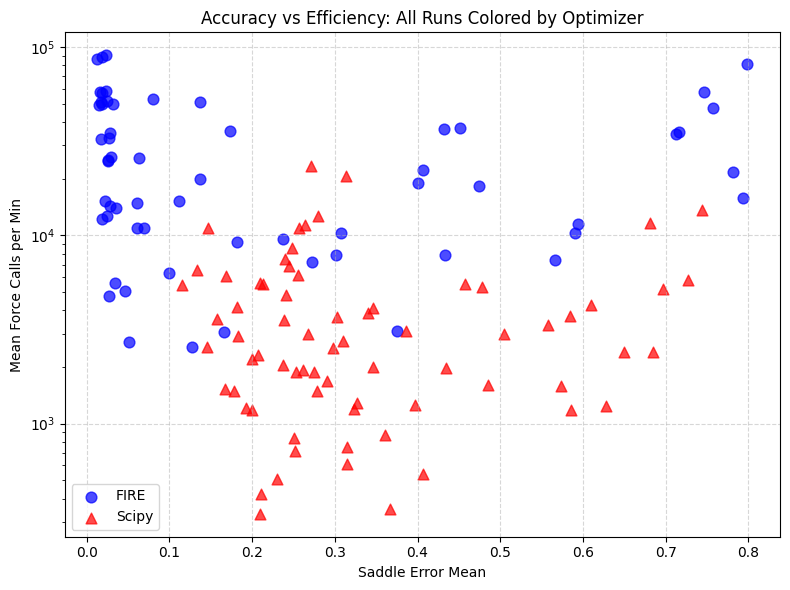

In [465]:
import matplotlib.pyplot as plt

# --- Split data by optimizer ---
fire_runs = agg_df[agg_df['optimizer'] == 'FIRE']
scipy_runs = agg_df[agg_df['optimizer'] == 'Scipy']

# --- Plot ---
plt.figure(figsize=(8, 6))

plt.scatter(
    fire_runs['saddle_error_mean'],
    fire_runs['mean_force_calls_per_min'],
    color='blue', label='FIRE', alpha=0.7, s=60, marker='o'
)
plt.scatter(
    scipy_runs['saddle_error_mean'],
    scipy_runs['mean_force_calls_per_min'],
    color='red', label='Scipy', alpha=0.7, s=60, marker='^'
)

# --- Labels, scale, and legend ---
plt.xlabel('Saddle Error Mean')
plt.ylabel('Mean Force Calls per Min')
plt.title('Accuracy vs Efficiency: All Runs Colored by Optimizer')
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
